In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit

# Eikon Theraputics: Take Home Assignment
Author: Thomas Lee

In [2]:
# Importing the data...
dose_responses = pd.read_csv("Dose_response_JD.csv")

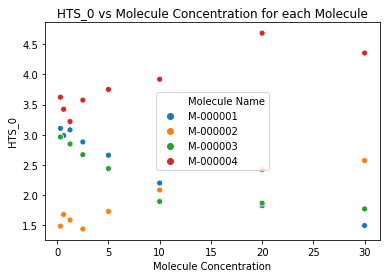

In [3]:
"""
Initial exploration of data. Plotting out the individual molecules on their own reveals vaguely sigmoidal-shaped data.
"""
grouped = dose_responses.groupby(['Molecule Name', 'Molecule Concentration']).mean().reset_index()
sns.scatterplot(data=grouped, x='Molecule Concentration', y='HTS_0', hue='Molecule Name');
plt.title('HTS_0 vs Molecule Concentration for each Molecule');

In [4]:
# THIS CELL IS FOR UTILITIES

# SOURCE for sigmoid function: https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y

def RMSE(actual, fitted):
    return np.sqrt(np.mean((actual-fitted)**2))

def rsquared(actual, residuals):
    return 1 - np.sum(residuals**2)/np.sum((actual-np.mean(actual))**2)

# Consider any point outside of [Q1-1.5*IQR, Q3-1.5*IQR] will be considered an outlier
# Returns a DataFrame with outliers removed
def remove_outliers(data):
    first_quart = np.percentile(data['HTS_0'], 25)
    third_quart = np.percentile(data['HTS_0'], 75)
    IQR = third_quart - first_quart
    return data[(data['HTS_0'] >= first_quart-1.5*IQR) & (data['HTS_0'] <= third_quart+1.5*IQR)]

label_font = {
    'size': 18
}

## Fitting the curve.
#### The following functions all help generate the sigmoidal curve and visualizations for the data.
The general sigmoidal function I am using is:
$$y=\frac{L}{1+e^{-k*(x-x_0)}} + b$$

$L$ is for scaling. $x_0$ gives the curve the freedom to shift along the x-axis. $k$ gives the freedom to change the orientation of the graph and scaling width-wise. $b$ allows the function to have a non-zero y-intercept.

The function which does the actual exporting of the .png is the export_graph() function. Running it will export a .png with the scatter plots and fitted curves.

In [5]:
def plot_fit_curve(to_plot, concentration, HTS_0, meth='dogbox'):
    """
    Fits the inputted data to a sigmoidal curve and plots the curve. 
    
    :to_plot: subplot ax to plot the line on
    :concentration: concentration data
    :HTS_0: HTS_0 data
    :return: the optimal parameters for the sigmoidal curve
    """
    popt, pcov = curve_fit(sigmoid, concentration, HTS_0, method=meth)
    x_vals = np.linspace(0, 30, 100)
    y_vals = sigmoid(x_vals, popt[0], popt[1], popt[2], popt[3])
    to_plot.plot(x_vals, y_vals)
    return popt # Returns optimal params

def least_squares_fit(to_plot, concentration, HTS_0, meth='dogbox'): 
    """
    Fits the inputted data to a sigmoidal curve using least-squares method and plots the curve.
    Considers concentration and HTS_0 to be two random variables that are jointly distributed. Thus, the best 
    least-squares predictor of this joint distribution is E(Y|X). 
    
    :to_plot: subplot ax to plot the line on
    :concentration: concentration data
    :HTS_0: HTS_0 data
    :return: the optimal parameters for the sigmoidal curve
    """
    grouped = dose_responses.groupby('Molecule Concentration').mean().reset_index()
    popt, pcov = curve_fit(sigmoid, grouped['Molecule Concentration'], grouped['HTS_0'], method=meth)
    x_vals = np.linspace(0, 30, 100)
    y_vals = sigmoid(x_vals, popt[0], popt[1], popt[2], popt[3])
    to_plot.plot(x_vals, y_vals)
    return popt # Returns optimal params
    
def plot_molecules(fit_func=None):
    """
    Plot scatter plots for all molecules side-by-side.
    
    :fit_func: if True, draw fitted sigmoidal curve on each scatter plot
    :returns: nothing
    """
    data = [dose_responses[dose_responses['Molecule Name'] == 'M-000001'],\
            dose_responses[dose_responses['Molecule Name'] == 'M-000002'],\
            dose_responses[dose_responses['Molecule Name'] == 'M-000003'],\
            dose_responses[dose_responses['Molecule Name'] == 'M-000004']]
    colors = ['b', 'y', 'g', 'm'] # Just for aesthetics
    
    fig, ax = plt.subplots(2, 2, figsize=(10,7))
    fig.set_tight_layout({"pad": 2})
    counter = 0
    for i in [0,1]:
        for j in [0, 1]:
            ax[i, j].scatter(data[counter]['Molecule Concentration'], data[counter]['HTS_0'], color=colors[counter])
            
            if fit_func:
                params = fit_func(ax[i, j], data[counter]['Molecule Concentration'], data[counter]['HTS_0'])
                actual = data[counter]['HTS_0']
                fitted = sigmoid(data[counter]['Molecule Concentration'], params[0], params[1], params[2], params[3])
                calculated_rmse = RMSE(actual, fitted)
                print(f'M-00000{counter+1} RMSE: {calculated_rmse}')
            
            ax[i, j].set_title(f'M-00000{counter+1}')
            ax[i, j].set_xlabel('Molecule Concentration')
            ax[i, j].set_ylabel('HTS_0')
            
            counter += 1
def single_plot(data, ax=plt, remove_out=False, fit_func=plot_fit_curve, meth='dogbox', color='b'):
    """
    Plots a single scatter plot for inputted data.
    
    :data: DataFrame with columns 'Molecule Concentration' and 'HTS_0'
    :ax: The axis to plot the scatter plot and curve on
    :remove_out: If True, removes outliers before plotting scatter plot and curve
    :fit_func: Curve-fitting function to use
    :returns: nothing
    """
    plt.rcParams["figure.figsize"] = (15,10)
    
    if remove_out:
        data = remove_outliers(data)
    
    ax.scatter(data['Molecule Concentration'], data['HTS_0'], c=color)
    params = fit_func(ax, data['Molecule Concentration'], data['HTS_0'])
    ax.set_xlabel('Molecule Concentration', fontdict=label_font)
    ax.set_ylabel('HTS_0', fontdict=label_font)
    
    actual = data['HTS_0']
    fitted = sigmoid(data['Molecule Concentration'], params[0], params[1], params[2], params[3])
    residuals = actual-fitted
    calculated_rmse = RMSE(actual, fitted)
    calculated_rsquared = rsquared(actual, residuals)
    residual_sd = np.std(residuals)
    values = '\n'.join([f'R^2={round(calculated_rsquared, 3)}',
                        f'SD={round(residual_sd, 3)}',
                        f'RMSE={round(calculated_rmse, 3)}',
                        f'Parameters: L={round(params[0], 3)}, x0={round(params[1], 3)}, k={round(params[2], 3)}, b={round(params[3], 3)}'])
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.7, 0.95, values, fontsize=14, verticalalignment='top', transform=ax.transAxes, bbox=props)
    
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

def export_graph():
    """
    Generates a .png file with the visualizations.
    """
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize = (20,40), tight_layout = True)
    single_plot(dose_responses[dose_responses['Molecule Name'] == 'M-000001'], ax1, color='b')
    ax1.set_title('M-000001', fontdict=label_font)
    single_plot(dose_responses[dose_responses['Molecule Name'] == 'M-000002'], ax2, color='y')
    ax2.set_title('M-000002', fontdict=label_font)
    single_plot(dose_responses[dose_responses['Molecule Name'] == 'M-000003'], ax3, color='g')
    ax3.set_title('M-000003', fontdict=label_font)
    single_plot(dose_responses[dose_responses['Molecule Name'] == 'M-000004'], ax4, color='m')
    ax4.set_title('M-000004', fontdict=label_font)
    plt.savefig("Molecules.png")

M-000001 RMSE: 0.3464300689306648
M-000002 RMSE: 0.30478818611612435
M-000003 RMSE: 0.3337204267942369
M-000004 RMSE: 0.39834728826377047


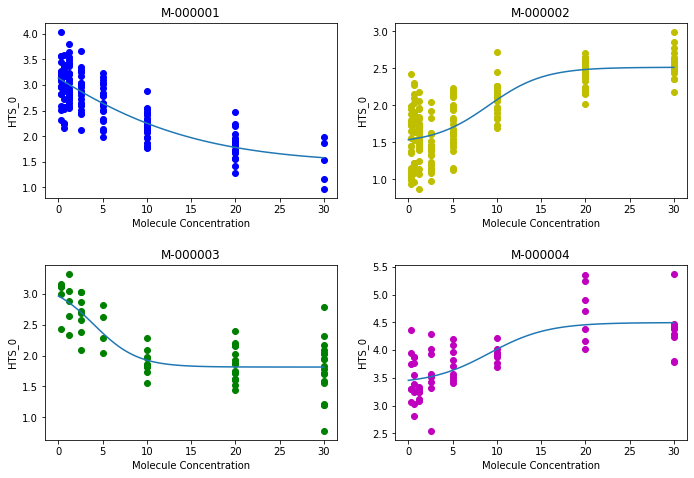

In [6]:
# Visualizing the plots side-by-side.
plot_molecules(fit_func=plot_fit_curve)

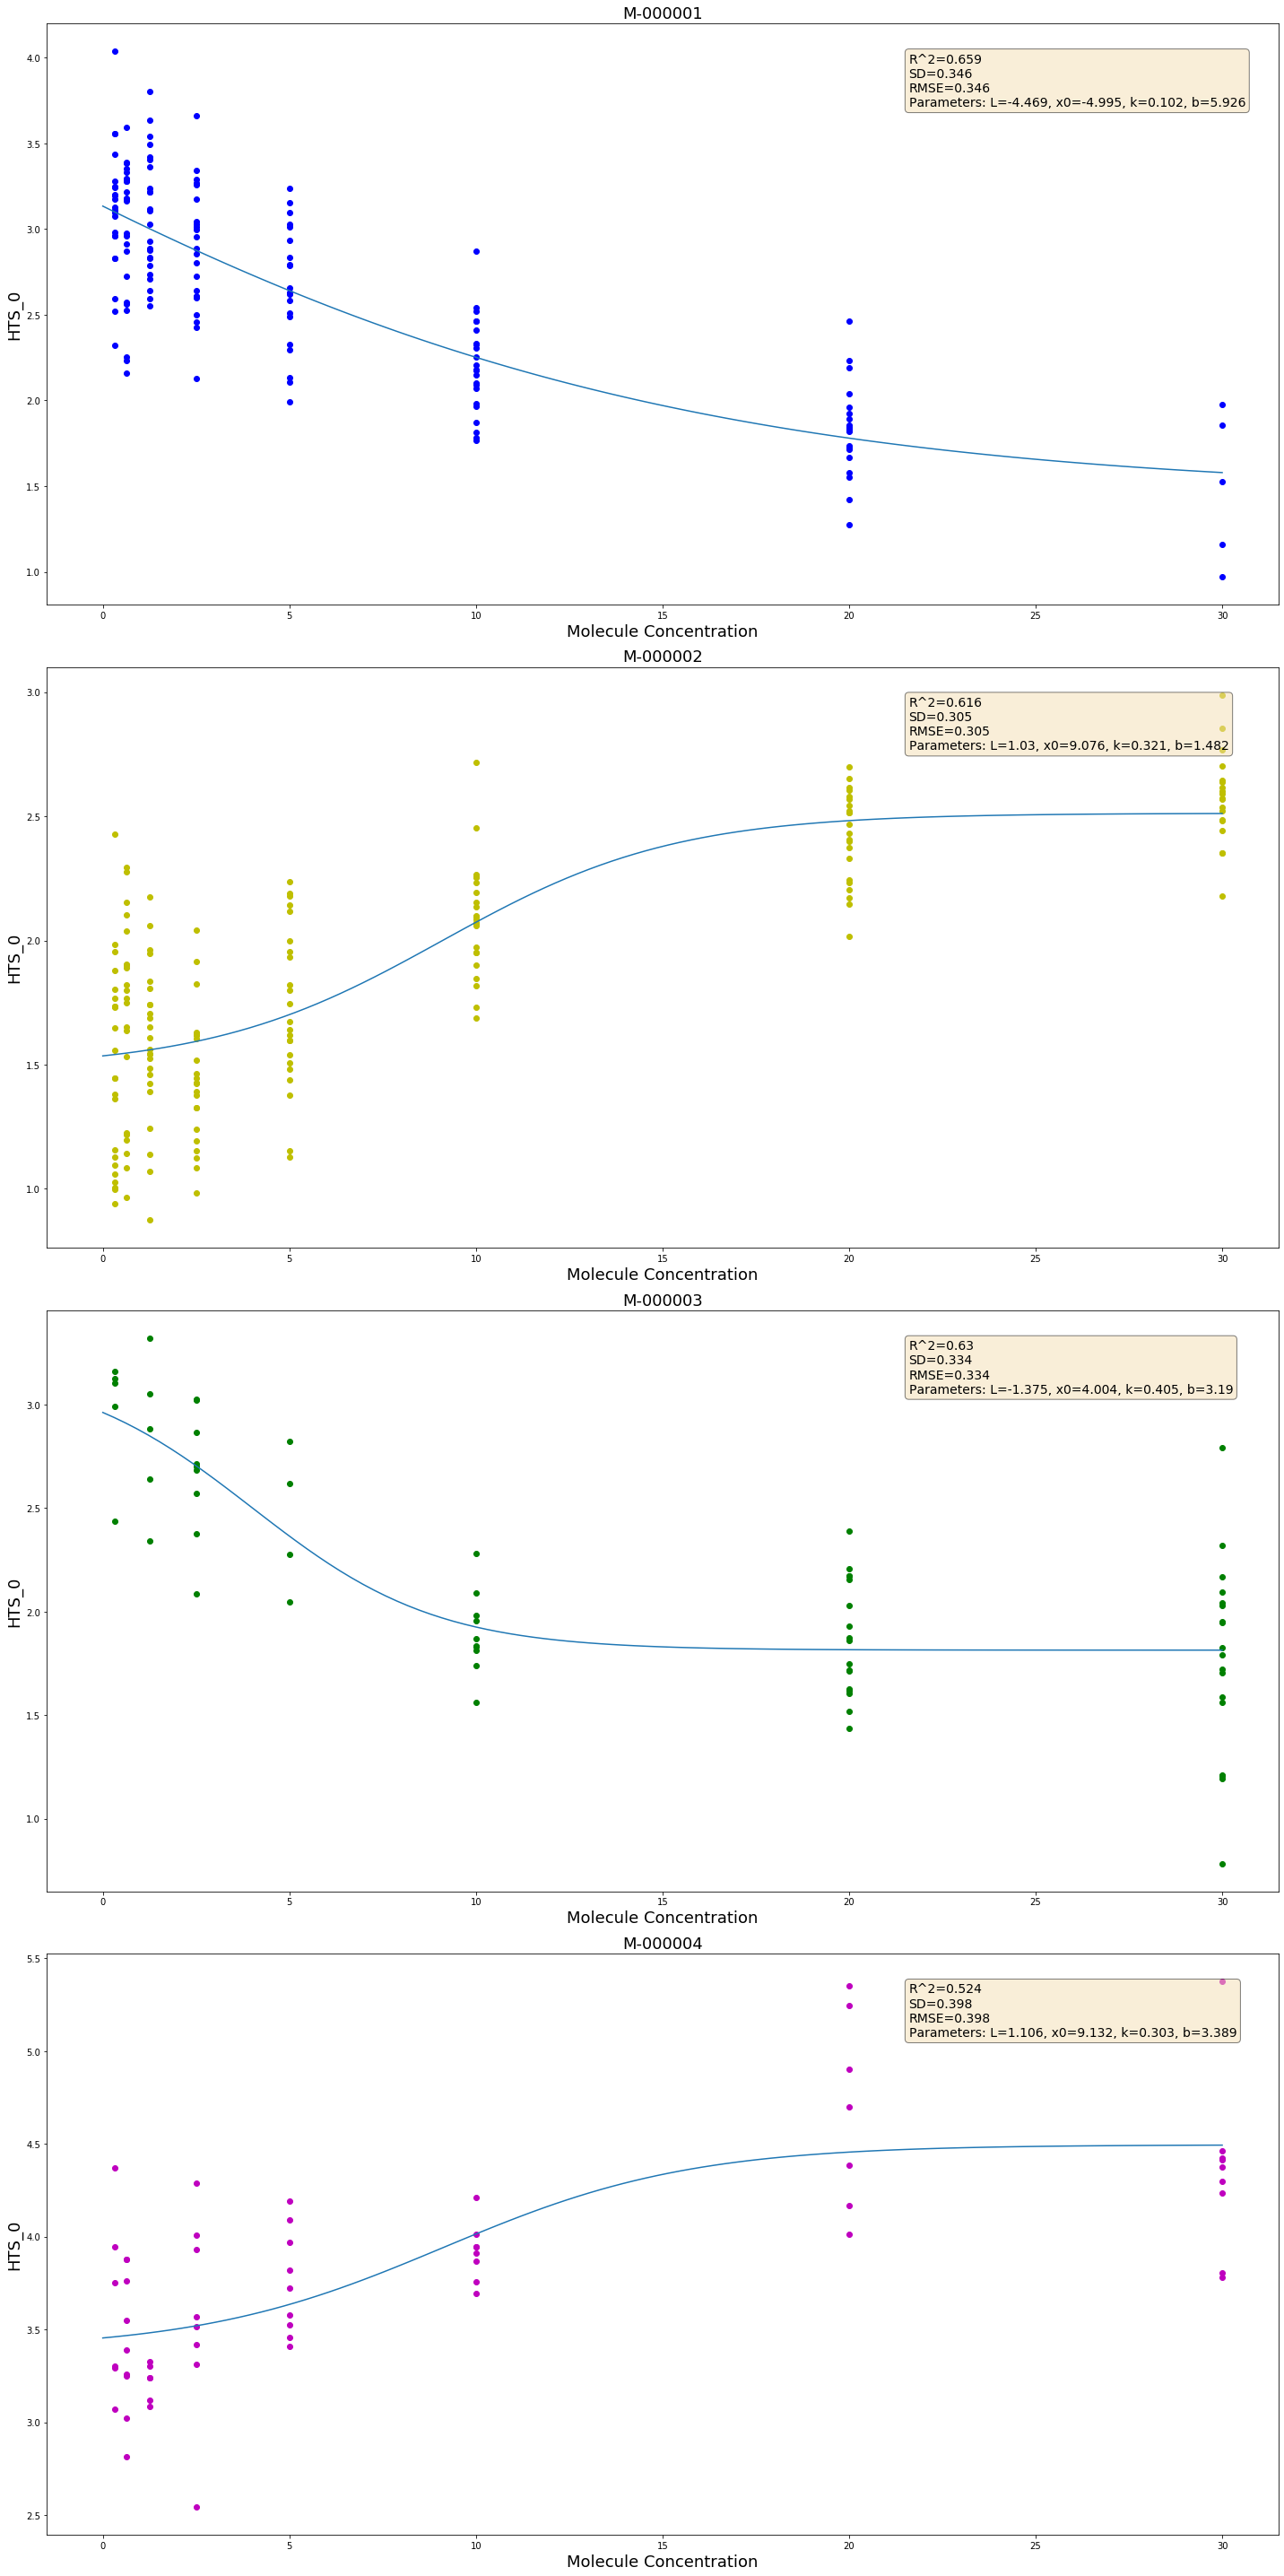

In [7]:
# Export the .png
export_graph()